1)	получение первичного изображения аэросъемки местности из памяти системы;
2)	определение координаты точки (пикселя) предполагаемой цели на исходной картинке;
3)	получение изображения с камеры системы;
4)	сопоставление алгоритмом изображений и получение облака реперных точек;
5)	поиск центов облака точек для каждого из изображений;
6)	перерасчет координат крайних точек для вложенного изображения в координаты исходного изображения:
I.	в случае нахождения цели внутри периметра крайних точек происходит смена изображения аэросъемки для следующего этапа;
II.	иначе исходное изображение аэросъемки меняться не будет;
7)	расчет относительного положения точки цели и крайних точек и перевод в координаты вложенного изображения;
8)	расчет ошибки по горизонтали и вертикали преобразованной точки цели и центра изображения;
9)	получившиеся ошибка поступает на вход системы управления.


In [1]:
import os
os.chdir("..")

import cv2
import torch
import random
import numpy as np
from copy import deepcopy

import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

# MPS acceleration is available on MacOS 12.3+
# pip install torch torchvision torchaudio

# importing required libraries 
import matplotlib.pyplot as plt 
import matplotlib.image as img 

In [2]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
_default_cfg = deepcopy(default_cfg)
_default_cfg['coarse']['temp_bug_fix'] = True  # set to False when using the old ckpt
matcher = LoFTR(config=_default_cfg)
matcher.load_state_dict(torch.load("weights/indoor_ds_new.ckpt")['state_dict'])
matcher = matcher.eval() #cuda()

In [3]:
img0_pths = ["Dataset/1/1.1/1_1.png", "Dataset/1/1.2/2_1.png", "Dataset/1/1.3/3_5.png", "Dataset/1/1.4/1_2.png", "Dataset/1/1.1/5_1.png"]

img1_pth = "Dataset/1/1.2/" + random.choice(os.listdir("Dataset/1/1.2/"))

In [4]:
img0_raw = cv2.imread(img0_pths[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img0_pths[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None] / 255. #.cuda()
img1 = torch.from_numpy(img1_raw)[None][None] / 255.
batch = {'image0': img0, 'image1': img1}

target_x, target_y = 320, 240

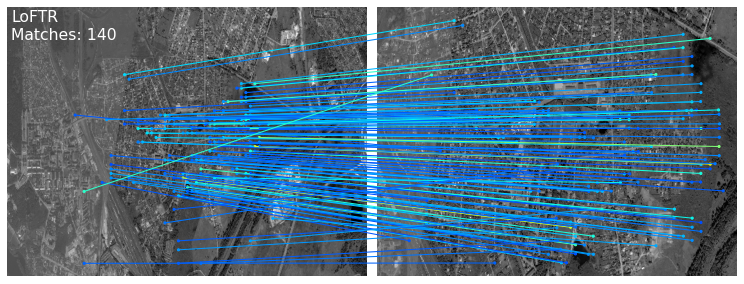

In [5]:
# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

#Center
w, h = 640, 480
M, mask = cv2.findHomography(mkpts0, mkpts1, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)

weap_center = [w / 2, h / 2]
center_p = np.float32(weap_center).reshape(-1, 1, 2)
center_p = cv2.perspectiveTransform(center_p, M)[0, 0, :]
# print(weap_center, center_p)
x, y = center_p[0], center_p[1]
# print(x, y)

# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)
fig.savefig('Dataset/1/loft/12.png')

In [8]:
ctr1_x, ctr1_y = 0, 0
ctr2_x, ctr2_y = 0, 0

for i in range(len(mkpts0)):
    ctr1_x += mkpts0[i][0]
    ctr1_y += mkpts0[i][1]
    ctr2_x += mkpts1[i][0]
    ctr2_y += mkpts1[i][1]

ctr1_x /= len(mkpts0)
ctr1_y /= len(mkpts0)
ctr2_x /= len(mkpts0)
ctr2_y /= len(mkpts0)

print(ctr1_x, ctr1_y)
print(x, y)
print(ctr2_x, ctr2_y)

341.7142857142857 251.54285714285714
353.88846 263.64877
398.52968720027377 268.82888525554114


In [9]:
max1_x, max1_y = 0, 0 # UR
min1_x, min1_y = 1e6, 1e6 # DL

for i in range(len(mkpts0)):
    if mkpts0[i][0] > max1_x:
        max1_x = mkpts0[i][0]
    if mkpts0[i][0] < min1_x:
        min1_x = mkpts0[i][0]
    if mkpts0[i][1] > max1_y:
        max1_y = mkpts0[i][1]
    if mkpts0[i][1] < min1_y:
        min1_y = mkpts0[i][1]

print(min1_x, min1_y)
print(max1_x, max1_y)

if ctr1_x > min1_x and max1_x > ctr1_x and ctr1_y > min1_y and ctr1_y < max1_y:
    print(True)
else:
    print(False)

120.0 120.0
472.0 456.0
True


In [10]:
rel2_x = (ctr1_x - min1_x)/(max1_x - min1_x)
kord2_x = w*rel2_x

rel2_y = (ctr1_y - min1_y)/(max1_y - min1_y)
kord2_y = h*rel2_y

print(kord2_x, kord2_y)

403.1168831168832 187.9183673469388


In [16]:
# reading the image 
img1 = img.imread(img0_pths[1]) 

real_y, real_x, k = img1.shape
print(real_x, real_y)

scale_x, scale_y = real_x/w, real_y/h
print(scale_x, scale_y)

1787 795
2.7921875 1.65625


[]

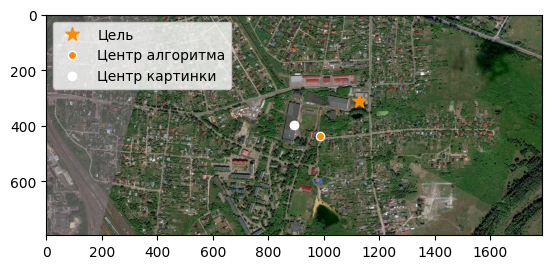

In [32]:
# displaying the image 
plt.imshow(img1)

plt.scatter(kord2_x*scale_x, kord2_y*scale_y, marker='*', color='darkorange', label='Цель', s=100)
plt.scatter(x*scale_x, y*scale_y, marker='o', color='darkorange', edgecolors='white', label='Центр алгоритма')
plt.scatter(w/2*scale_x, h/2*scale_y, marker='o', color='white', label='Центр картинки')

plt.legend(loc='upper left')
plt.plot()

In [33]:
err2_x, err2_y = kord2_x - x, kord2_y - y
print(err2_x, err2_y)

49.22842486493005 -75.73040584642058
